# Find Keywords of Abstract via TF_IDF
TF = Term Frequency = Frequency of Term in Document / # Terms in Document

IDF = Inverse Document Frequency = log(# Documents) / # of Documents with term

## Define Functions to Sort TF_IDF
Needed at very end

In [127]:
#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

## Load Pre-Processed Data (punctuation removed, etc)

In [1]:
#Loading in dataset
import pandas as pd
from pandas import ExcelWriter, ExcelFile

df = pd.read_csv("export_dataframe.csv")
df.head()

,Field,Abstract
0,in 1971 goodman and rose predicted the occurre...,Physics
1,we present pseudopotential coefficients for th...,Physics
2,nose has modified newtonian dynamics so as to ...,Physics
3,we provide the first evidence for a holographi...,Physics
4,a technique is demonstrated for polarization d...,Physics


# Get Basic Statistics of How Many Words per Abstract

Average 160 words per abstract.

Very high standard deviation (114), implying abstract lengths greatly vary.

Min 5 words in an abstract.

Max 1,479 words in an abstract

In [131]:
# Count how many words are in each Abstract and save into word_count
df['word_count'] = df['Field'].apply(lambda x:
len(str(x).split(" ")))
df.head(4)

df.word_count.describe()

count    2000.000000
mean      160.299000
std       114.022121
min         5.000000
25%        89.000000
50%       137.000000
75%       205.000000
max      1479.000000
Name: word_count, dtype: float64

In [32]:
# Libraries for text preprocessing
import re
import nltk
nltk.download('stopwords') # Need to download only once
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
#nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\548253\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


# Lemmatize Data

In [132]:
# Get Stopwords
stop_words = set(stopwords.words("english"))

# Append Custom stopwords that are known to affect this dataset in particular
new_words = ["author", "de"] #"de" appears frequently; like foreign papers.  
stop_words = stop_words.union(new_words)

corpus = []
for i in range(0, df.shape[0]):
    text = df['Field'][i]
    
    # Pre-processing such as removing puncutation would be done here if
    # not already done
    
    ##Convert to list from string
    text = text.split()
    
    ##Stemming
    ps=PorterStemmer()
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)

## Preview Results of Lemmatization
...by looking at an an arbitary entry.  Looks pretty reasonable.

In [133]:
temp_int = 600
print("BEFORE LEMMATIZATION")
print(df['Field'][temp_int])
print("")
print("AFTER LEMMATIZATION")
print(corpus[temp_int])

BEFORE LEMMATIZATION
in recent years there has been considerable controversy regarding the game of squash as played in north america this controversy concerns the differences between the english and the north american na squash rules with regard to court size type of ball and scoring methods since the english rules are used in all international play na players are obviously at a disadvantage in such competitions consequently many people have suggested that u s and canadian players adopt the english rules one criticism of this suggestion is that the english scoring system similar to that used in volleyball and badminton results in games that are overly protracted in comparison with those played by the na system a point is won on every rally note for example the following quote author

AFTER LEMMATIZATION
recent year considerable controversy regarding game squash played north america controversy concern difference english north american na squash rule regard court size type ball scoring 

# Plot Most Frequent Words Across All Abstracts

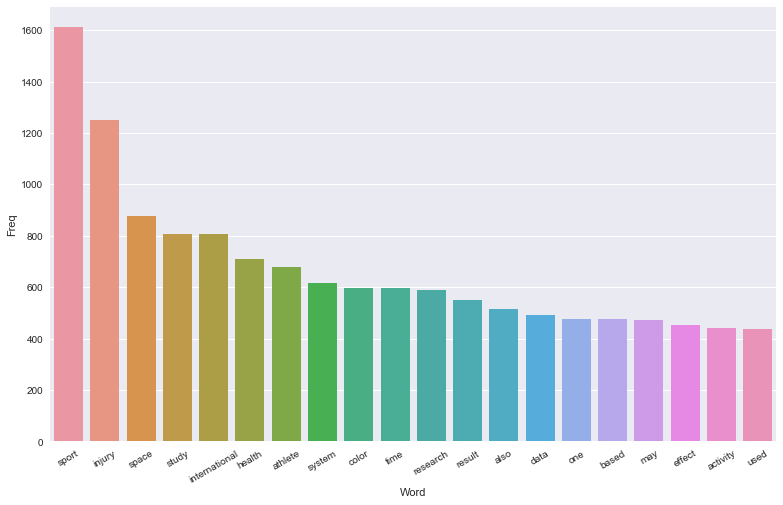

In [142]:
#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
#Barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30);

# Plot Most Frequent Bi-Grams Across All Abstracts

                Bi-gram  Freq
0          sport injury   172
1        sport medicine   136
2         sport related   100
3     physical activity    95
4            space time    90
5           health care    81
6          united state    79
7             long term    75
8           risk factor    73
9           phase space    67
10       sport activity    67
11          human right    64
12        public health    63
13  sport participation    59
14       overuse injury    46
15           heart rate    46
16        paper present    43
17    three dimensional    41
18      family planning    41
19                en la    41


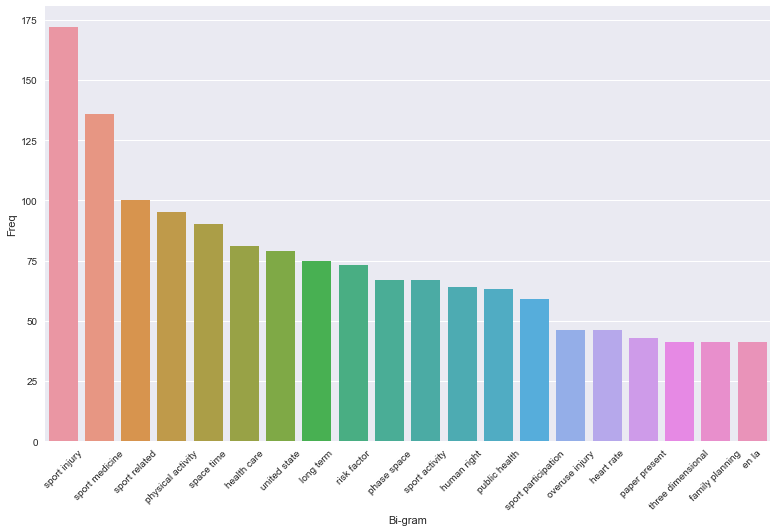

In [144]:
#Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top2_words = get_top_n2_words(corpus, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)
#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45);

                               Tri-gram  Freq
0              sport related concussion    33
1                  sport related injury    22
2             world health organization    18
3                95 confidence interval    18
4                   play important role    16
5            anterior cruciate ligament    16
6             international human right    15
7                       injury per 1000    13
8                traumatic brain injury    12
9                    sport injury child    11
10          international space station    10
11                   free space optical    10
12                     patient mean age    10
13                sudden cardiac arrest    10
14             sport medicine physician    10
15                 sudden cardiac death    10
16               linear energy transfer     9
17                   human right health     9
18              family planning program     9
19  international conference population     9


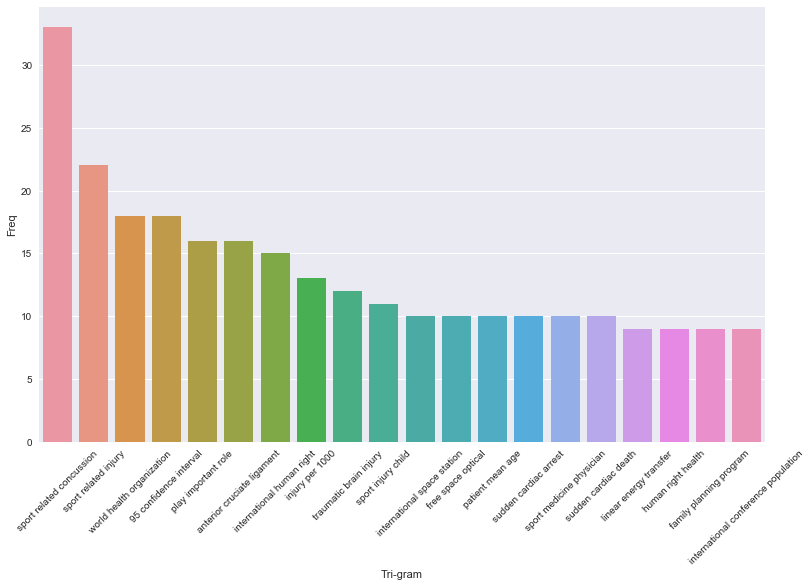

In [145]:
#Most frequently occuring Tri-grams
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top3_words = get_top_n3_words(corpus, n=20)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
print(top3_df)
#Barplot of most freq Tri-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=45);

## Apply TF_IDF and Find Top Keywords for a single document

In [148]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Vectorize with Words, Bi-grams, and Tri-grams
vectorizer = CountVectorizer(stop_words = 'english', ngram_range=(1, 3))

X = vectorizer.fit_transform(corpus)
word_counts = X.toarray()

transformer = TfidfTransformer(smooth_idf = True, use_idf = True)
transformer.fit(word_counts)
abstract_count = 5
doc = corpus[abstract_count]

# get feature names for later
feature_names=vectorizer.get_feature_names()

tf_idf_vector = transformer.transform(vectorizer.transform([doc]))

#sort the tf-idf vectors by descending order of scores with defined function
sorted_items=sort_coo(tf_idf_vector.tocoo())

#extract only the top n as only top scored keywords will be "right"
keywords=extract_topn_from_vector(feature_names,sorted_items,5)
 
# now print the results
print("\nAbstract:")
print(df['Field'][abstract_count])
print("\nKeywords:")
for k in keywords:
    print(k,keywords[k])


Abstract:
we propose that space time at the smallest scales is in reality a causal set a locally finite set of elements endowed with a partial order corresponding to the macroscopic relation that defines past and future we explore how a lorentzian manifold can approximate a causal set noting in particular that the thereby defined effective dimensionality of a given causal set can vary with length scale finally we speculate briefly on the quantum dynamics of causal sets indicating why an appropriate choice of action can reproduce general relativity in the classical limit author

Keywords:
causal set 0.324
causal 0.254
set 0.196
scale 0.085
vary length scale 0.081


## Loop Through All Abstracts and Get 5 Keywords Per Abstract

In [173]:
keyword_dict_array = []

# Select an arbitrary # of keywords here whose results seem reasonable.
# 5 seemed to get enough relavent keywords without picking up too many
# irrelevant ones.
num_keywords = 5 

for abstract_counter in range(0, df.shape[0]):
    doc = corpus[abstract_counter]
    tf_idf_vector = transformer.transform(vectorizer.transform([doc]))

    #sort tf-idf vectors by descending order of scores with defined function
    sorted_items=sort_coo(tf_idf_vector.tocoo())

    #extract only the top n as only top scored keywords will be "right"
    keywords = extract_topn_from_vector(feature_names, sorted_items, \
                                        num_keywords)
    keyword_dict_array.append(keywords)

# Preview the top few keyword sets.  Note that every keyword has 
print("The first few abstracts' keywords are ...")
keyword_dict_array[0:3]

The first few abstracts' keywords are ...


[{'charge': 0.238,
  'photocurrent': 0.212,
  'light intensity': 0.193,
  'power dependence': 0.141,
  'half power': 0.141},
 {'pseudopotential': 0.225,
  'analytic form': 0.15,
  'fourier space': 0.142,
  'real': 0.123,
  'analytic': 0.118},
 {'equation': 0.146,
  'scaling': 0.142,
  'sub': 0.138,
  'dynamical': 0.138,
  'friction coefficient': 0.129}]

## Save the Data, Word Counts, and Keywords to an Excel File

In [172]:
df["Keyword"] = keyword_dict_array
df.to_excel("dataframe_with_keywords.xlsx")